# Model Creation and FEMAG Invocation

There are several ways to run FEMAG with femagtools: either using an existing FSL script or
 - by using a parametrized stator and magnet model or a user specified FSL fragment
 - by using an existing I7/A7 model file
 
The last 2 optionally in combination with one of the 7 FE simulation functions: cogg_calc, pm_rel_sim_fast, pm_sym_loss, mult_cal_fast, torq_calc, ld_lq_fast, psd_psq_fast.

In [1]:
import femagtools

Create the FSL command by referencing a model name:

In [2]:
femagtools.create_fsl('PM_270_L8')

['  exit_on_error=false',
 '  exit_on_end=false',
 '  verbosity=2',
 '',
 "model = 'PM_270_L8'",
 'load_model(model)',
 '',
 '',
 '  global_unit(mm)',
 '  pickdist(0.001)',
 '  cosys(polar)',
 '',
 'm.hc_min          =         95.000 --   Limit demagnetisa > 0:[%]Hc,<0:[kA/m]   ',
 'm.con_hdcopy      =          0.000 --   Hc-copy:Name:auto:0,intact:1, none:-1   ',
 'm.b_max           =          2.400 --   Max Induction [T] in colorgradation     ',
 'm.b_min           =    0.0 --   Move inside: 0 , Move outside: > 0      ',
 'm.calc_fe_loss    =          1.000 --   Calc. FE-Loss:0:no, 1:yes, 2:m-output   ',
 'm.eval_force      =          0.000 --   Eval. force density > 0, no <= 0        ',
 'm.allow_draw      =          1.000 --   Draw Graphics :> 0: yes, 0:  no         ',
 'm.fline_dens      =          4.000 --   F-Lines: 1: small, 2: medium, 3:thick   ',
 'm.num_flines      =         20.000 --   Number of Field-lines:      < 100 > 2   ',
 'm.name_bch_log    =          0.000 --   Name

This produces a list of FSL commands which can be written to a file:

In [3]:
with open('femag.fsl', 'w') as f:
    f.write('\n'.join(femagtools.create_fsl('PM_270_L8')))

The FSL commands to create a FEMAG model can be created from parametrized stator and magnet models. This is done by setting up a Python dict consisting of a general set of parameters together with the stator, magnet and winding dicts:

In [4]:
machine = {
    "name": "PM 270 L8",
    "desc": "PM Motor 270mm 8 poles VMAGN",
    "poles": 8,
    "outer_diam": 0.26924,
    "bore_diam": 0.16192,
    "inner_diam": 0.11064,
    "airgap": 0.00075,
    "lfe": 0.08356,
    "stator": {
        "num_slots": 48,
        "mcvkey_yoke": 'M270-35A',
        "statorRotor3": {
            "slot_height": 0.0335,
            "slot_h1": 0.001,
            "slot_h2": 0.0,
            "slot_width": 0.00193,
            "slot_r1": 0.0001,
            "slot_r2": 0.00282,
            "wedge_width1": 0.00295,
            "wedge_width2": 0.0,
            "middle_line": 0.0,
            "tooth_width": 0.0,
            "slot_top_sh": 0.0}
    },
    "magnet": {
        "mcvkey_yoke": 'M270-35A',
        "magnetIronV": {
            "magn_angle": 145.0,
            "magn_height": 0.00648,
            "magn_width": 0.018,
            "condshaft_r": 0.05532,
            "magn_num": 1.0,
            "air_triangle": 1,
            "iron_hs": 0.0001,
            "gap_ma_iron": 0.0002,
            "iron_height": 0.00261,
            "magn_rem": 1.2,
            "iron_shape": 0.0802
        }
    },
    "windings": {
        "num_phases": 3,
        "num_layers": 1,
        "num_wires": 9,
        "coil_span": 6.0,
        "cufilfact": 0.4,
        "culength": 1.4,
        "slot_indul": 0.5e-3
    }
}

From such a model it is possible to create the FSL file by the help of pre-defined templates. To do so we first chose a working directory and set the directory of the MC/MCV files using the parameter 'magnetizingCurves':

In [6]:
import os
workdir = os.path.join(os.path.expanduser('~'), 'femag')
fslfile = 'femag.fsl'
with open(os.path.join(workdir, fslfile), 'w') as f:
    f.write('\n'.join(femagtools.create_fsl(machine)))
femag = femagtools.femag.Femag(workdir, magnetizingCurves='.')
femag.run(fslfile, options=['-g'])

/home/tar/femag/femag.out
(0lqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqk(B
(0x(B **** FSL ****                   FEMAG   Version 8.4.x (Rev. 2918) (0x(B
(0x(B Script Language Interpreter                                       (0x(B
(0mqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqj(B
Start: Mon Oct 30 15:04:46 2017

FSL...exe "femag.fsl"
New model "PM_270_L8", ""
Global unit is 0.001 m
Pick distance is 0.001
Set coordinate system to polar
Preprocessing CAD model FE-contr-data
Preprocessing CAD model basic_modpar
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Preprocessing CAD model STATOR_3
Postprocessing CAD model: nodedistance => ndst
Preprocessing CAD model Gen_winding
Preprocessing CAD model gen_pocfile
Preprocessing CAD model Magnet Iron V
Preprocessing CAD model connect_models
Save model and continue
FSL...halt

Stop: Mon Oct 30 15:05:01 2017
Elapsed time:     15s



To invoke a FE calculation another dict must be setup:

In [7]:
operatingConditions = {
    "angl_i_up": -30.0,
    "calculationMode": "pm_sym_fast",
    "num_move_steps": 0,
    "wind_temp": 60.0,
    "magn_temp": 60.0,
    "current": 150.0,
    "speed": 50.0,
    "airgap_induc": True
}

If we want to see some feedback a logger would be useful: 

In [8]:
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(message)s')

Now we can invoke FEMAG without creating an FSL file. The Femag object knows how to handle this:

In [9]:
r = femag(machine,
          operatingConditions, options=['-g'])

2017-10-30 15:07:25,896 Copy file M270-35A.MCV
2017-10-30 15:07:26,004 invoking xfemag64 -g femag.fsl
2017-10-30 15:10:41,301 xfemag64 exited with returncode 0 (num errs=0)
2017-10-30 15:10:41,310 Read BCH /home/tar/femag/PM_270_L8_061.BATCH


/home/tar/femag/femag.out
(0lqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqk(B
(0x(B **** FSL ****                   FEMAG   Version 8.4.x (Rev. 2918) (0x(B
(0x(B Script Language Interpreter                                       (0x(B
(0mqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqj(B
Start: Mon Oct 30 15:07:26 2017

FSL...exe "femag.fsl"
New model "PM_270_L8", ""
Global unit is 0.001 m
Pick distance is 0.001
Set coordinate system to polar
Preprocessing CAD model FE-contr-data
Preprocessing CAD model basic_modpar
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Preprocessing CAD model STATOR_3
Postprocessing CAD model: nodedistance => ndst
Preprocessing CAD model Gen_winding
Preprocessing CAD model gen_pocfile
Preprocessing CAD model Magnet Iron V
Preprocessing CAD model connect_models
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Run CAD model pm_sym_fast: max_nlit=84
Postprocessin

After a calculation has finished we can examine all the BCH values which are included in the result 'r'. For example the torque:

In [10]:
r.machine['torque']

301.6727

If we have set the parameter 'airgap_induc' to True we can read the produced airgap values:

In [10]:
airgap = femag.read_airgap_induction()

2017-10-27 17:19:41,708 /home/tar/femag/bag.dat: Period 90.400000 max phi 90.400000 B amp 1.549171


and create a nice plot with the base harmonic:

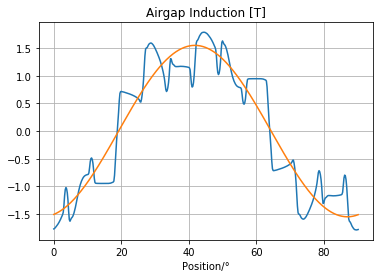

In [11]:
import matplotlib.pylab as pl
import femagtools.plot
femagtools.plot.airgap(airgap)
pl.show()

We can even create a graphical report of the results:

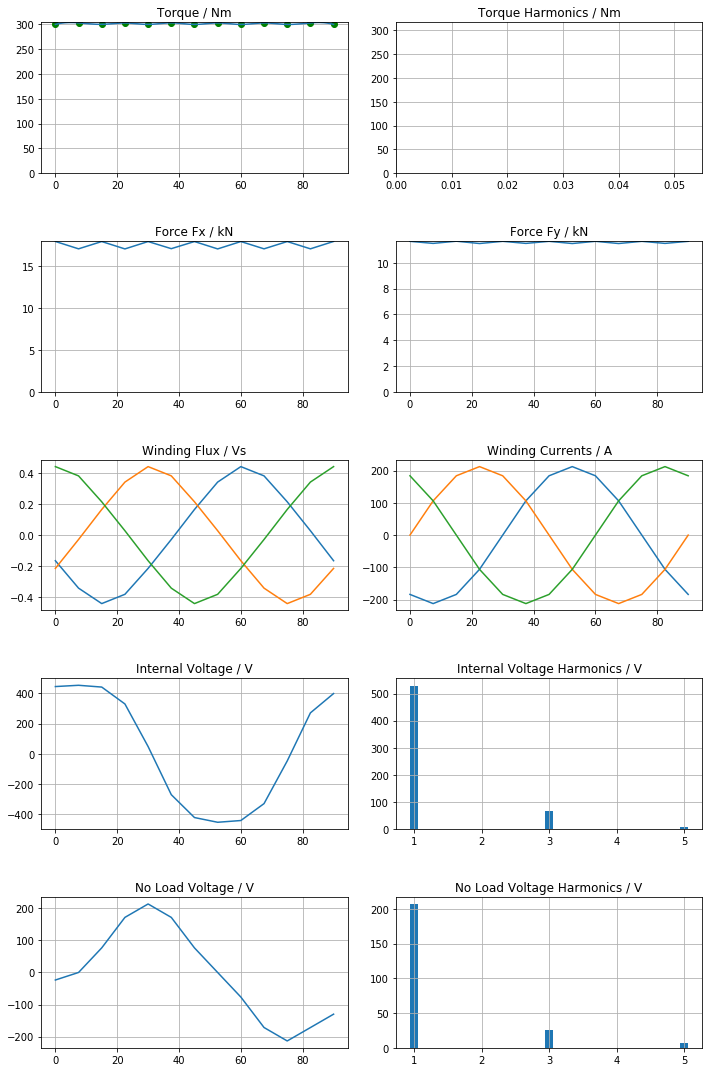

In [12]:
femagtools.plot.pmrelsim(r)
pl.show()

## Model creation with user specific model

To create a user specific model is based on a FSL fragment that includes the necessary nodechain and material definitions. This script can then be included in the magnet dict of the machine:

In [13]:
machine['magnet'] = dict(
        mcvkey_yoke="dummy",
        magnetFsl=dict(
            magn_height=0.008,
            shaft_diam=0.01,
            slot_width=0.004,
            magn_width=0.022,
            content_template="spokefml.fsl"
        )
)

The FSL fragment should make use of the globally defined variables as described in the femagtools documentation.

In [14]:
fslfile = 'femag.fsl'
with open(os.path.join(workdir, fslfile), 'w') as f:
    f.write('\n'.join(femagtools.create_fsl(machine)))
femag.run(fslfile, options=['-g'])

2017-10-27 17:19:44,095 MC Dir /home/tar/Documents/semafor/pres/fat-2017/femagtools-workshop
2017-10-27 17:19:44,096 invoking xfemag64 -g femag.fsl
2017-10-27 17:19:51,131 xfemag64 exited with returncode 0 (num errs=0)


/home/tar/femag/femag.out
(0lqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqk(B
(0x(B **** FSL ****                   FEMAG   Version 8.4.x (Rev. 2918) (0x(B
(0x(B Script Language Interpreter                                       (0x(B
(0mqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqj(B
Start: Fri Oct 27 17:19:44 2017

FSL...exe "femag.fsl"
New model "PM_270_L8", ""
Global unit is 0.001 m
Pick distance is 0.001
Set coordinate system to polar
Preprocessing CAD model FE-contr-data
Preprocessing CAD model basic_modpar
Preprocessing CAD model CU-Losses-1
Preprocessing CAD model CU-Losses-2
Preprocessing CAD model STATOR_3
Postprocessing CAD model: nodedistance => ndst
Preprocessing CAD model Gen_winding
Preprocessing CAD model gen_pocfile
fml 0.33 (c) 2012-2017 Siemens AG
Reference node distance is 0.281295
Reference node distance is 0.393813
Reference node distance is 0.562589
Mesh superelement: con1=0
Mesh superelement: con1=0
New sub